# 03 Training

Train Duckling_II and record embedding dynamics.

**Two-phase approach:**
1. **Diagnostic run:** Short, no recording. Verify learning, measure speed, find the loss curve shape.
2. **Recorded run:** Full run with W snapshots every step.

We don't know where the interesting dynamics are until we see the loss curve. Measure twice, cut once.

In [1]:
# === Parameters ===

# Model architecture (from README)
VOCAB_SIZE = 8192
N_EMBD = 128
N_HEAD = 2
N_LAYER = 8
N_POSITIONS = 512
N_INNER = 512  # 4x hidden dim

# Training
LEARNING_RATE = 1e-4
BATCH_SIZE = 16
WEIGHT_DECAY = 0.01
MAX_GRAD_NORM = 1.0
SEED = 42

# Precision: Use HuggingFace's bf16=True for PROPER mixed precision
# This keeps optimizer states in float32 (so Adam doesn't die from underflow)
# while doing forward/backward in bf16 (for speed and memory)
# Weights get quantized to bf16 after updates - giving us fimbulwinter dynamics
# 
# DO NOT use model.to(torch.bfloat16) - that breaks the optimizer!
USE_BF16 = True

# Diagnostic run
DIAGNOSTIC_STEPS = 2000

# Recorded run (set after diagnostic)
RECORDED_STEPS = 10000  # Adjust based on diagnostic results
RECORD_EVERY = 1        # Record W every N steps

# Paths
DATASET_PATH = "tokenized_dataset"
TOKEN_MAPPING_PATH = "token_mapping.json"
OUTPUT_DIR = "runs"

In [2]:
import json
import time
from pathlib import Path
from datetime import datetime

import torch
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_from_disk
from transformers import (
    GPT2Config,
    GPT2LMHeadModel,
    Trainer,
    TrainingArguments,
    set_seed,
)
from transformers.trainer_callback import TrainerCallback
from tqdm.auto import tqdm

# Device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print(f"Using device: {device}")

set_seed(SEED)
print("Imports complete.")

Using device: mps
Imports complete.


## Load Dataset

In [3]:
# Load tokenized dataset
dataset = load_from_disk(DATASET_PATH)
print(f"Dataset loaded: {len(dataset):,} sequences")

# Load token mapping for reference
with open(TOKEN_MAPPING_PATH) as f:
    token_mapping = json.load(f)
print(f"Token mapping loaded: {token_mapping['live_tokens']} live, {token_mapping['dead_tokens']} dead")

Dataset loaded: 921,519 sequences
Token mapping loaded: 6144 live, 2048 dead


## Create Model

In [4]:
# Model configuration
config = GPT2Config(
    vocab_size=VOCAB_SIZE,
    n_embd=N_EMBD,
    n_head=N_HEAD,
    n_layer=N_LAYER,
    n_positions=N_POSITIONS,
    n_inner=N_INNER,
    activation_function='gelu',
    resid_pdrop=0.0,
    embd_pdrop=0.0,
    attn_pdrop=0.0,
    layer_norm_epsilon=1e-5,
    initializer_range=0.02,
    use_cache=False,  # Disable KV cache for training
)

model = GPT2LMHeadModel(config)

# NOTE: We do NOT convert to bf16 here!
# The Trainer's bf16=True handles mixed precision properly:
# - Forward/backward in bf16
# - Optimizer states in float32 (prevents underflow)
# - Weight updates applied in float32, then quantized to bf16

n_params = sum(p.numel() for p in model.parameters())
print(f"Model created: {n_params:,} parameters")
print(f"W (embedding) shape: {model.transformer.wte.weight.shape}")
print(f"W dtype: {model.transformer.wte.weight.dtype} (will be bf16 during training via AMP)")

Model created: 2,700,544 parameters
W (embedding) shape: torch.Size([8192, 128])
W dtype: torch.float32 (will be bf16 during training via AMP)


## Data Collator

For causal LM, labels = input_ids (shifted internally by the model).

In [5]:
class CausalLMCollator:
    """Simple collator that creates labels from input_ids."""
    
    def __call__(self, examples):
        input_ids = torch.tensor([ex["input_ids"] for ex in examples], dtype=torch.long)
        return {
            "input_ids": input_ids,
            "labels": input_ids.clone(),  # Model handles shifting
        }

collator = CausalLMCollator()
print("Data collator ready.")

Data collator ready.


---

# Phase 1: Diagnostic Run

Short run to verify learning and measure performance. No recording.

In [6]:
# Training arguments for diagnostic
diagnostic_args = TrainingArguments(
    output_dir="diagnostic_run",
    overwrite_output_dir=True,
    
    # Training
    max_steps=DIAGNOSTIC_STEPS,
    per_device_train_batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    max_grad_norm=MAX_GRAD_NORM,
    
    # Mixed precision - the RIGHT way
    # This keeps optimizer states in float32, does forward/backward in bf16
    bf16=USE_BF16,
    
    # Optimizer
    optim="adamw_torch",
    adam_beta1=0.9,
    adam_beta2=0.999,
    adam_epsilon=1e-8,
    
    # Schedule
    lr_scheduler_type="linear",
    warmup_steps=0,
    
    # Logging
    logging_steps=50,
    logging_first_step=True,
    report_to="none",
    
    # Performance
    dataloader_num_workers=0,
    
    # Disable saving during diagnostic
    save_strategy="no",
    
    # Seed
    seed=SEED,
)

print(f"Diagnostic run: {DIAGNOSTIC_STEPS} steps, batch size {BATCH_SIZE}")
print(f"Mixed precision: bf16={USE_BF16}")
print(f"Tokens per step: {BATCH_SIZE * N_POSITIONS:,}")

Diagnostic run: 2000 steps, batch size 16
Mixed precision: bf16=True
Tokens per step: 8,192


In [7]:
class LossTracker(TrainerCallback):
    """Track loss at every step for plotting."""
    
    def __init__(self):
        self.losses = []
        self.steps = []
        self.start_time = None
        
    def on_train_begin(self, args, state, control, **kwargs):
        self.start_time = time.time()
        
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and "loss" in logs:
            self.losses.append(logs["loss"])
            self.steps.append(state.global_step)

loss_tracker = LossTracker()

In [8]:
# Fresh model for diagnostic
set_seed(SEED)
model = GPT2LMHeadModel(config)
# NO model.to(torch.bfloat16) - let Trainer handle it!

# Create trainer
trainer = Trainer(
    model=model,
    args=diagnostic_args,
    train_dataset=dataset,
    data_collator=collator,
    callbacks=[loss_tracker],
)

# Run diagnostic
print(f"Starting diagnostic run... (bf16={USE_BF16} via Trainer AMP)")
start_time = time.time()
trainer.train()
elapsed = time.time() - start_time

print(f"\nDiagnostic complete!")
print(f"Time: {elapsed:.1f}s ({DIAGNOSTIC_STEPS / elapsed:.1f} steps/sec)")
print(f"Final loss: {loss_tracker.losses[-1]:.4f}")

Starting diagnostic run... (bf16=True via Trainer AMP)


/Users/jefferyharrell/Workshop/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
1,9.003900
50,8.273400
100,7.445600
150,6.794000
200,6.293300
250,5.918600
300,5.614600
350,5.364800
400,5.160600
450,5.006600



Diagnostic complete!
Time: 217.1s (9.2 steps/sec)
Final loss: 4.0471


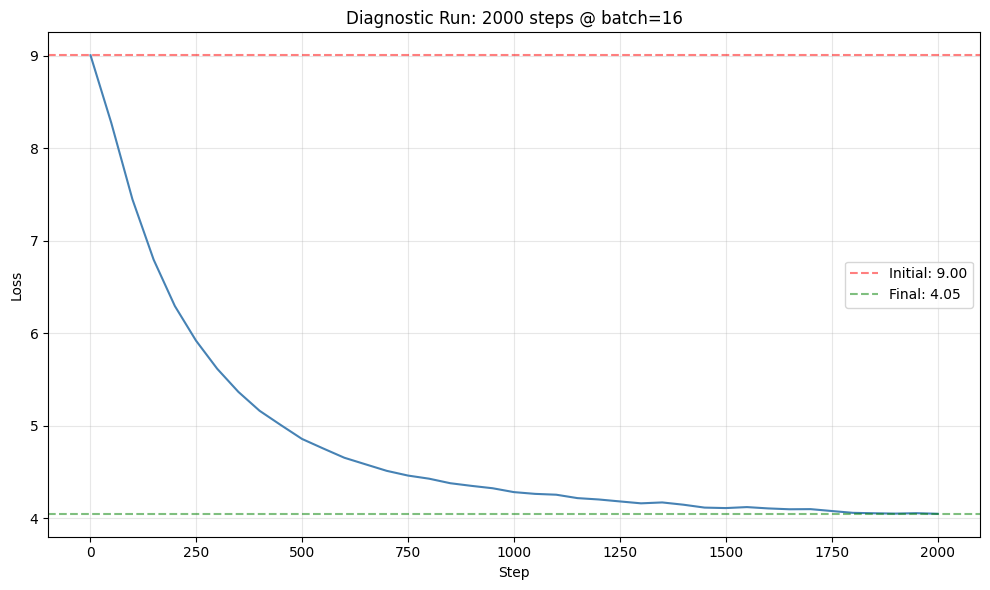

Saved: diagnostic_loss.png


In [9]:
# Plot loss curve
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(loss_tracker.steps, loss_tracker.losses, color='steelblue', linewidth=1.5)
ax.set_xlabel('Step')
ax.set_ylabel('Loss')
ax.set_title(f'Diagnostic Run: {DIAGNOSTIC_STEPS} steps @ batch={BATCH_SIZE}')
ax.grid(True, alpha=0.3)

# Add annotations
ax.axhline(y=loss_tracker.losses[0], color='red', linestyle='--', alpha=0.5, label=f'Initial: {loss_tracker.losses[0]:.2f}')
ax.axhline(y=loss_tracker.losses[-1], color='green', linestyle='--', alpha=0.5, label=f'Final: {loss_tracker.losses[-1]:.2f}')
ax.legend()

plt.tight_layout()
plt.savefig('diagnostic_loss.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print("Saved: diagnostic_loss.png")

In [10]:
# Analysis
print("=" * 50)
print("DIAGNOSTIC ANALYSIS")
print("=" * 50)

initial_loss = loss_tracker.losses[0]
final_loss = loss_tracker.losses[-1]
loss_drop = initial_loss - final_loss
steps_per_sec = DIAGNOSTIC_STEPS / elapsed

print(f"\nLoss: {initial_loss:.4f} → {final_loss:.4f} (dropped {loss_drop:.4f})")
print(f"Speed: {steps_per_sec:.1f} steps/sec")
print(f"\nAt current speed:")
print(f"  10K steps: {10000 / steps_per_sec / 60:.1f} minutes")
print(f"  Recording budget (12K steps): {12000 / steps_per_sec / 60:.1f} minutes")

# Is the model learning?
expected_initial = np.log(VOCAB_SIZE)  # Random guess baseline
print(f"\nExpected initial loss (random): {expected_initial:.2f}")
print(f"Actual initial loss: {initial_loss:.2f}")

if loss_drop > 0.5:
    print("\n✓ Model is learning! Loss decreased significantly.")
elif loss_drop > 0.1:
    print("\n~ Model is learning slowly. Loss decreased modestly.")
else:
    print("\n✗ Model may not be learning. Loss barely changed.")

DIAGNOSTIC ANALYSIS

Loss: 9.0039 → 4.0471 (dropped 4.9568)
Speed: 9.2 steps/sec

At current speed:
  10K steps: 18.1 minutes
  Recording budget (12K steps): 21.7 minutes

Expected initial loss (random): 9.01
Actual initial loss: 9.00

✓ Model is learning! Loss decreased significantly.


## Decision Point

Based on the diagnostic, decide:
1. **Is the model learning?** If not, debug before recording.
2. **How many steps do we need?** Look at where loss flattens.
3. **Recording density:** Every step? Every 10?

Adjust `RECORDED_STEPS` and `RECORD_EVERY` below before Phase 2.

---

# Phase 2: Recorded Run

Full training with W snapshots saved at each recording interval.

In [ ]:
class EmbeddingRecorder(TrainerCallback):
    """
    Record embedding matrix W at specified intervals.
    
    Saves to HDF5 for efficient streaming access.
    """
    
    def __init__(self, output_path, record_every=1, live_tokens=6144):
        self.output_path = Path(output_path)
        self.record_every = record_every
        self.live_tokens = live_tokens
        
        self.losses = []
        self.steps_recorded = []
        self.W_snapshots = []  # Will convert to array at end
        self.start_time = None
        
    def on_train_begin(self, args, state, control, **kwargs):
        self.start_time = time.time()
        # Record initial W
        self._record_W(kwargs['model'], step=0)
        
    def on_step_end(self, args, state, control, **kwargs):
        step = state.global_step
        if step % self.record_every == 0:
            self._record_W(kwargs['model'], step)
            
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and "loss" in logs:
            self.losses.append((state.global_step, logs["loss"]))
    
    def _record_W(self, model, step):
        """Snapshot the embedding matrix."""
        W = model.transformer.wte.weight.detach().cpu().clone()
        self.W_snapshots.append(W)
        self.steps_recorded.append(step)
        
    def save(self):
        """Save all recordings to disk."""
        import h5py
        
        self.output_path.mkdir(parents=True, exist_ok=True)
        
        # Stack W snapshots: (n_steps, vocab_size, hidden_dim)
        W_all = torch.stack(self.W_snapshots).numpy()
        
        # Save to HDF5
        h5_path = self.output_path / "embeddings.h5"
        with h5py.File(h5_path, 'w') as f:
            f.create_dataset('W', data=W_all, compression='gzip', compression_opts=4)
            f.create_dataset('steps', data=np.array(self.steps_recorded))
            f.create_dataset('live_tokens', data=self.live_tokens)
            
            # Loss curve
            if self.losses:
                loss_steps, loss_values = zip(*self.losses)
                f.create_dataset('loss_steps', data=np.array(loss_steps))
                f.create_dataset('loss_values', data=np.array(loss_values))
        
        print(f"Saved: {h5_path}")
        print(f"  W shape: {W_all.shape}")
        print(f"  Size: {W_all.nbytes / 1e9:.2f} GB")
        
        return h5_path

print("EmbeddingRecorder ready.")

In [ ]:
# === ADJUST THESE BASED ON DIAGNOSTIC ===
# RECORDED_STEPS = 10000  # Already set in parameters
# RECORD_EVERY = 1        # Already set in parameters

n_snapshots = RECORDED_STEPS // RECORD_EVERY + 1  # +1 for initial

# With proper mixed precision, weights are stored as float32 but computed in bf16
# The recorded W will be float32 (master weights)
bytes_per_element = 4  # float32
snapshot_size_mb = VOCAB_SIZE * N_EMBD * bytes_per_element / 1e6
total_size_gb = n_snapshots * snapshot_size_mb / 1000

print(f"Recorded run plan:")
print(f"  Steps: {RECORDED_STEPS:,}")
print(f"  Record every: {RECORD_EVERY} step(s)")
print(f"  Total snapshots: {n_snapshots:,}")
print(f"  Precision: float32 master weights (bf16 used for forward/backward)")
print(f"  Snapshot size: {snapshot_size_mb:.1f} MB")
print(f"  Estimated total: {total_size_gb:.1f} GB")

if total_size_gb > 24:
    print(f"\n⚠️  WARNING: Exceeds 24 GB budget! Reduce RECORDED_STEPS or increase RECORD_EVERY.")
else:
    print(f"\n✓ Within 24 GB budget")

In [ ]:
# Fresh model
set_seed(SEED)
model = GPT2LMHeadModel(config)
# NO model.to(torch.bfloat16) - let Trainer handle it!

# Output directory with timestamp
run_name = datetime.now().strftime("%Y%m%d_%H%M%S")
run_dir = Path(OUTPUT_DIR) / run_name

# Recording callback
recorder = EmbeddingRecorder(
    output_path=run_dir,
    record_every=RECORD_EVERY,
    live_tokens=token_mapping['live_tokens']
)

# Training arguments with proper mixed precision
recorded_args = TrainingArguments(
    output_dir=str(run_dir),
    overwrite_output_dir=True,
    
    max_steps=RECORDED_STEPS,
    per_device_train_batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    max_grad_norm=MAX_GRAD_NORM,
    
    # Mixed precision - the RIGHT way
    bf16=USE_BF16,
    
    optim="adamw_torch",
    adam_beta1=0.9,
    adam_beta2=0.999,
    adam_epsilon=1e-8,
    
    lr_scheduler_type="linear",
    warmup_steps=0,
    
    logging_steps=100,
    logging_first_step=True,
    report_to="none",
    
    save_strategy="no",  # We save embeddings ourselves
    dataloader_num_workers=0,
    seed=SEED,
)

print(f"Ready to run {RECORDED_STEPS} steps with recording. (bf16={USE_BF16} via Trainer AMP)")
print(f"Output: {run_dir}")

In [ ]:
# Create trainer
trainer = Trainer(
    model=model,
    args=recorded_args,
    train_dataset=dataset,
    data_collator=collator,
    callbacks=[recorder],
)

# Run!
print(f"Starting recorded run ({RECORDED_STEPS} steps)...")
start_time = time.time()
trainer.train()
elapsed = time.time() - start_time

print(f"\nTraining complete!")
print(f"Time: {elapsed/60:.1f} minutes ({RECORDED_STEPS / elapsed:.1f} steps/sec)")

In [ ]:
# Save recordings
h5_path = recorder.save()

# Save run metadata
metadata = {
    "run_name": run_name,
    "steps": RECORDED_STEPS,
    "record_every": RECORD_EVERY,
    "batch_size": BATCH_SIZE,
    "learning_rate": LEARNING_RATE,
    "vocab_size": VOCAB_SIZE,
    "live_tokens": token_mapping['live_tokens'],
    "dead_tokens": token_mapping['dead_tokens'],
    "n_embd": N_EMBD,
    "elapsed_seconds": elapsed,
    "steps_per_second": RECORDED_STEPS / elapsed,
}

with open(run_dir / "metadata.json", 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"Saved: {run_dir / 'metadata.json'}")

In [ ]:
# Final loss plot
if recorder.losses:
    steps, losses = zip(*recorder.losses)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(steps, losses, color='steelblue', linewidth=1.5)
    ax.set_xlabel('Step')
    ax.set_ylabel('Loss')
    ax.set_title(f'Recorded Run: {RECORDED_STEPS} steps')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(run_dir / 'loss_curve.png', dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()
    print(f"Saved: {run_dir / 'loss_curve.png'}")

## Summary

This notebook:
1. Ran a diagnostic to verify learning and measure speed
2. Ran a full training with embedding recording

**Outputs:**
- `runs/<timestamp>/embeddings.h5` — W snapshots over training
- `runs/<timestamp>/metadata.json` — Run configuration
- `runs/<timestamp>/loss_curve.png` — Loss visualization

**Next step:** Analyze dead token dynamics (notebook 04).